In [ ]:
# === colab configuration ===
# Skip this cell if running demo file locally!

from google.colab import drive
import sys

# setting paths
repository_path = '/content/time-series-forecasting-with-transformers/'
datasets_path = repository_path + 'datasets/'
sys.path.insert(0, repository_path)

# cloning project repository and downloading dataset
# drive.mount('/content/drive')
! test ! -d $repository_path && git clone https://github.com/francescobaraldi/time-series-forecasting-with-transformers
# ! test ! -d $dataset_path && cp -R $dataset_path_drive $dataset_path
%cd $repository_path

# setting branch and pulling updates
branch = 'main'
! git checkout $branch
! git pull origin $branch

executing_on_colab = True

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

from dataset import StockDatasetSW_multistep, StockDatasetSW_singlestep, YahooDatasetSW_singlestep
from model import Transformer, TransformerDecoder, TransformerDecoder_v2, DotProductAttention
from eval_plot import eval_mae, eval_mae_decoder, plot_scores
from utils import scaler, MyMinMaxScaler

try:
    executing_on_colab
except NameError:
    executing_on_colab = False

## Load datasets

In [2]:
if not executing_on_colab:
    sp500_dataset_path = "datasets/spx.csv"
    yahoo_dataset_path = "datasets/yahoo_stock.csv"
else:
    sp500_dataset_path = datasets_path + "spx.csv"
    yahoo_dataset_path = datasets_path + "yahoo_stock.csv"
sp500 = pd.read_csv(sp500_dataset_path)
yahoo = pd.read_csv(yahoo_dataset_path)

## Prepare sp500 dataset

In [3]:
sp500_data = sp500['close'].to_numpy()
sp500_data = torch.from_numpy(sp500_data).to(torch.float32)

sp500_trainset = sp500_data[0:int(len(sp500_data) * 0.7)]
sp500_testset = sp500_data[int(len(sp500_data) * 0.7):]

sp500_trainset_scaled, sp500_testset_scaled = scaler(sp500_trainset, sp500_testset)

## Prepare yahoo dataset

In [4]:
date_time = pd.to_datetime(yahoo['Date'], format='%Y.%m.%d')
day = 24*60*60
year = (365.2425)*day
timestamp_s = date_time.map(pd.Timestamp.timestamp)
yahoo['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
yahoo['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
yahoo['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
yahoo['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

yahoo_data = yahoo[['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'Day sin', 'Day cos', 'Year sin', 'Year cos']]
yahoo_class_idx = 3
yahoo_trainset = yahoo_data.iloc[:int(len(yahoo_data) * 0.7)]
yahoo_testset = yahoo_data.iloc[int(len(yahoo_data) * 0.7):]
scaler = MinMaxScaler()
scaler.fit(yahoo_trainset)
yahoo_trainset_scaled = scaler.transform(yahoo_trainset)
yahoo_testset_scaled = scaler.transform(yahoo_testset)

## Transformer std.

In [ ]:
trainset, testset = yahoo_trainset_scaled, yahoo_testset_scaled

device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 32
learning_rate = 0.01
epochs = 10
window_len = 7
output_len = 3
train_dataset = StockDatasetSW_multistep(trainset, window_len, output_len)
test_dataset = StockDatasetSW_multistep(testset, window_len, output_len)
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
model = Transformer(seq_len=window_len, num_encoder=6, num_decoder=6, input_size=1, output_size=output_len, d_model=512, num_heads=8, feedforward_dim=1024).to(device)
loss_fun = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train_maes = []
test_maes = []
for e in tqdm(range(epochs)):
    model.eval()
    train_mae = eval_mae(model, train_dl, device)
    test_mae = eval_mae(model, test_dl, device)
    train_maes.append(train_mae.cpu())
    test_maes.append(test_mae.cpu())
    print(f"Epoch {e} - Train MAE {train_mae} - Test MAE {test_mae}")
    model.train()
    for i, (src, trg, trg_y) in enumerate(train_dl):
        src, trg, trg_y = src.to(device), trg.to(device), trg_y.to(device)
        optimizer.zero_grad()
        out = model(src, trg)
        loss = loss_fun(out, trg_y)
        if i % 50 == 0:
            print(f'loss {loss.cpu().item():.3f}')
        loss.backward()
        optimizer.step()
plot_scores(train_maes, test_maes)

## Transformer decoder

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0 - Train MAE 2456.787353515625 - Test MAE 3071.738037109375
loss 2361.023193


  4%|▍         | 2/50 [00:00<00:15,  3.06it/s]

Epoch 1 - Train MAE 2439.67236328125 - Test MAE 3054.35693359375
loss 2506.852051


  6%|▌         | 3/50 [00:00<00:12,  3.62it/s]

Epoch 2 - Train MAE 2398.79296875 - Test MAE 3015.427734375
loss 2413.199951


  8%|▊         | 4/50 [00:01<00:11,  3.88it/s]

Epoch 3 - Train MAE 2331.30712890625 - Test MAE 2946.666015625
loss 2285.625977


 10%|█         | 5/50 [00:01<00:11,  3.81it/s]

Epoch 4 - Train MAE 2231.64013671875 - Test MAE 2845.86376953125
loss 2333.245850


 12%|█▏        | 6/50 [00:01<00:11,  3.96it/s]

Epoch 5 - Train MAE 2097.0361328125 - Test MAE 2712.551513671875
loss 2104.378418


 14%|█▍        | 7/50 [00:01<00:10,  4.19it/s]

Epoch 6 - Train MAE 1930.3489990234375 - Test MAE 2546.812744140625
loss 1969.461304
Epoch 7 - Train MAE 1733.8331298828125 - Test MAE 2348.783935546875


 16%|█▌        | 8/50 [00:02<00:09,  4.40it/s]

loss 1697.752319
Epoch 8 - Train MAE 1504.3658447265625 - Test MAE 2118.783447265625


 18%|█▊        | 9/50 [00:02<00:09,  4.51it/s]

loss 1510.736084


 20%|██        | 10/50 [00:02<00:08,  4.59it/s]

Epoch 9 - Train MAE 1241.509765625 - Test MAE 1857.2088623046875
loss 1294.538452


 22%|██▏       | 11/50 [00:02<00:08,  4.66it/s]

Epoch 10 - Train MAE 946.7892456054688 - Test MAE 1564.4835205078125
loss 995.366516
Epoch 11 - Train MAE 624.9581298828125 - Test MAE 1241.065673828125
loss 575.118958


 26%|██▌       | 13/50 [00:03<00:07,  4.90it/s]

Epoch 12 - Train MAE 348.20355224609375 - Test MAE 913.7611694335938
loss 270.188202
Epoch 13 - Train MAE 276.87396240234375 - Test MAE 728.8915405273438
loss 267.632172


 30%|███       | 15/50 [00:03<00:06,  5.06it/s]

Epoch 14 - Train MAE 261.0033874511719 - Test MAE 638.7306518554688
loss 254.534760
Epoch 15 - Train MAE 260.1115417480469 - Test MAE 628.5868530273438
loss 231.842529


 34%|███▍      | 17/50 [00:03<00:06,  5.10it/s]

Epoch 16 - Train MAE 259.6256408691406 - Test MAE 599.1773681640625
loss 239.232391
Epoch 17 - Train MAE 259.3340759277344 - Test MAE 607.26318359375
loss 256.998993


 38%|███▊      | 19/50 [00:04<00:06,  5.10it/s]

Epoch 18 - Train MAE 259.44049072265625 - Test MAE 603.1616821289062
loss 265.025909
Epoch 19 - Train MAE 259.9825439453125 - Test MAE 612.3953247070312
loss 256.250061


 42%|████▏     | 21/50 [00:04<00:05,  5.12it/s]

Epoch 20 - Train MAE 260.44451904296875 - Test MAE 615.60400390625
loss 221.902695
Epoch 21 - Train MAE 260.74908447265625 - Test MAE 605.2362060546875
loss 308.435608


 46%|████▌     | 23/50 [00:05<00:05,  5.07it/s]

Epoch 22 - Train MAE 261.1312561035156 - Test MAE 598.4710693359375
loss 284.241638
Epoch 23 - Train MAE 260.22882080078125 - Test MAE 599.687744140625
loss 269.276825


 50%|█████     | 25/50 [00:05<00:05,  4.87it/s]

Epoch 24 - Train MAE 260.2314758300781 - Test MAE 606.0361938476562
loss 238.416824


 52%|█████▏    | 26/50 [00:05<00:04,  4.84it/s]

Epoch 25 - Train MAE 260.81890869140625 - Test MAE 607.777099609375
loss 289.817810


 54%|█████▍    | 27/50 [00:05<00:04,  4.84it/s]

Epoch 26 - Train MAE 261.3747863769531 - Test MAE 598.3448486328125
loss 210.327286


 56%|█████▌    | 28/50 [00:06<00:04,  4.85it/s]

Epoch 27 - Train MAE 260.1789855957031 - Test MAE 609.1824340820312
loss 246.469513


 58%|█████▊    | 29/50 [00:06<00:04,  4.88it/s]

Epoch 28 - Train MAE 260.6515808105469 - Test MAE 598.0860595703125
loss 291.287079


 60%|██████    | 30/50 [00:06<00:04,  4.88it/s]

Epoch 29 - Train MAE 260.8800048828125 - Test MAE 605.3008422851562
loss 204.741226
Epoch 30 - Train MAE 261.0697937011719 - Test MAE 599.3667602539062


 62%|██████▏   | 31/50 [00:06<00:03,  4.92it/s]

loss 262.998901
Epoch 31 - Train MAE 260.95361328125 - Test MAE 599.577392578125
loss 248.157623


 66%|██████▌   | 33/50 [00:07<00:03,  5.04it/s]

Epoch 32 - Train MAE 261.4907531738281 - Test MAE 609.2394409179688
loss 240.169327
Epoch 33 - Train MAE 261.126220703125 - Test MAE 606.5906982421875


 68%|██████▊   | 34/50 [00:07<00:03,  4.74it/s]

loss 243.205246


 70%|███████   | 35/50 [00:07<00:03,  4.72it/s]

Epoch 34 - Train MAE 260.7906799316406 - Test MAE 601.711669921875
loss 259.456360
Epoch 35 - Train MAE 259.8863525390625 - Test MAE 601.170166015625


 72%|███████▏  | 36/50 [00:07<00:02,  4.77it/s]

loss 262.285217
Epoch 36 - Train MAE 260.06866455078125 - Test MAE 600.2554931640625
loss 249.180389


 76%|███████▌  | 38/50 [00:08<00:02,  4.86it/s]

Epoch 37 - Train MAE 260.5439758300781 - Test MAE 615.7819213867188
loss 299.184845
Epoch 38 - Train MAE 259.4229431152344 - Test MAE 612.8623046875
loss 258.625763


 80%|████████  | 40/50 [00:08<00:01,  5.04it/s]

Epoch 39 - Train MAE 260.07373046875 - Test MAE 599.7444458007812
loss 274.195282
Epoch 40 - Train MAE 259.6031494140625 - Test MAE 598.4720458984375
loss 255.565796


 84%|████████▍ | 42/50 [00:08<00:01,  5.05it/s]

Epoch 41 - Train MAE 260.05712890625 - Test MAE 603.2153930664062
loss 253.515335
Epoch 42 - Train MAE 260.9132385253906 - Test MAE 603.621337890625
loss 220.256149


 88%|████████▊ | 44/50 [00:09<00:01,  5.11it/s]

Epoch 43 - Train MAE 260.1582946777344 - Test MAE 600.2794189453125
loss 280.718658
Epoch 44 - Train MAE 260.3831481933594 - Test MAE 600.9945068359375
loss 247.082260


 92%|█████████▏| 46/50 [00:09<00:00,  5.11it/s]

Epoch 45 - Train MAE 260.0413513183594 - Test MAE 611.8609008789062
loss 250.707184
Epoch 46 - Train MAE 260.6886901855469 - Test MAE 608.2493286132812
loss 245.223709


 96%|█████████▌| 48/50 [00:10<00:00,  5.09it/s]

Epoch 47 - Train MAE 260.8954772949219 - Test MAE 607.1123046875
loss 222.455109
Epoch 48 - Train MAE 259.2425231933594 - Test MAE 598.474365234375
loss 204.884247


100%|██████████| 50/50 [00:10<00:00,  4.77it/s]


Epoch 49 - Train MAE 260.10498046875 - Test MAE 615.0297241210938
loss 281.955414


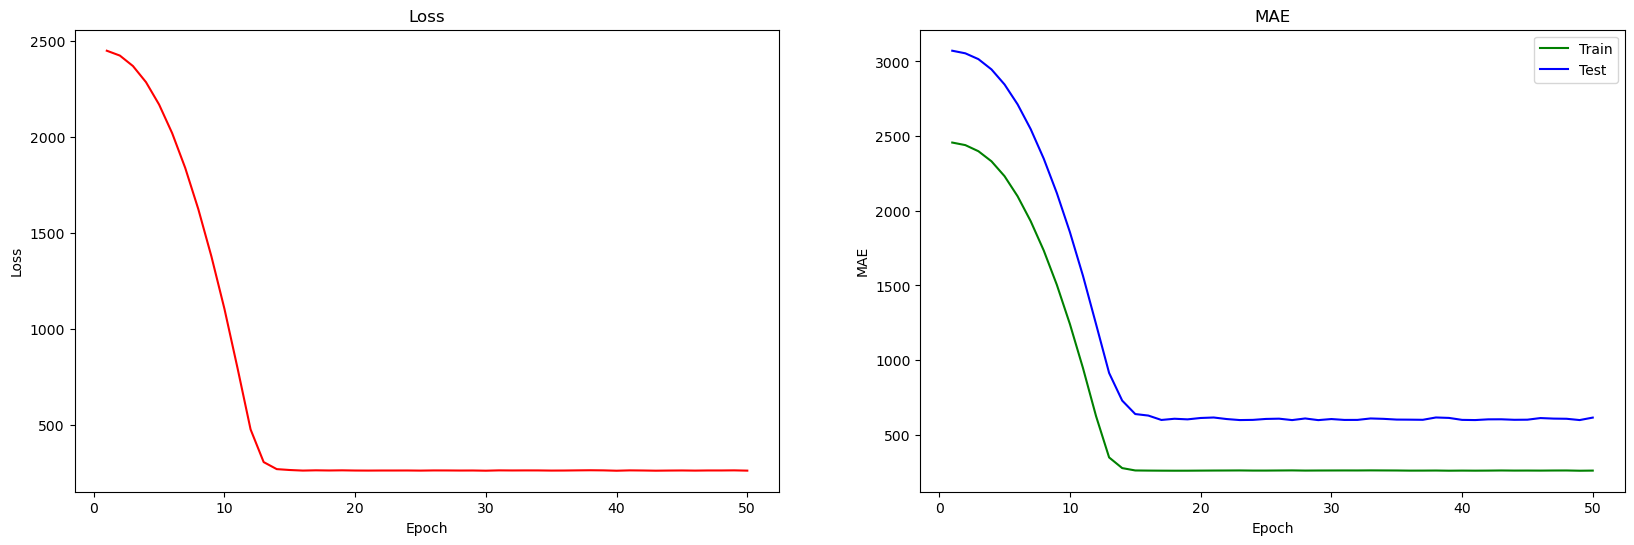

In [6]:
trainset, testset = yahoo_trainset.to_numpy(), yahoo_testset.to_numpy()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 32
learning_rate = 0.01
epochs = 50
window_len = 7
input_size = 10
output_size = 1
d_model = 20
train_dataset = YahooDatasetSW_singlestep(trainset, window_len, yahoo_class_idx)
test_dataset = YahooDatasetSW_singlestep(testset, window_len, yahoo_class_idx)
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
model = TransformerDecoder(seq_len=window_len, num_layer=1, input_size=input_size, output_size=output_size, d_model=d_model, num_heads=1, feedforward_dim=32).to(device)
loss_fun = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train_maes = []
test_maes = []
losses = []
for e in tqdm(range(epochs)):
    model.eval()
    train_mae = eval_mae_decoder(model, train_dl, device)
    test_mae = eval_mae_decoder(model, test_dl, device)
    train_maes.append(train_mae.cpu())
    test_maes.append(test_mae.cpu())
    print(f"Epoch {e} - Train MAE {train_mae} - Test MAE {test_mae}")
    model.train()
    avg_loss = 0
    count = 0
    for i, (src, trg) in enumerate(train_dl):
        src, trg = src.to(device), trg.to(device)
        optimizer.zero_grad()
        out = model(src)
        loss = loss_fun(out, trg)
        avg_loss += loss.cpu().detach().numpy().item()
        if i % 50 == 0:
            print(f'loss {loss.cpu().item():.6f}')
        loss.backward()
        optimizer.step()
        count += 1
    avg_loss /= count
    losses.append(avg_loss)
plot_scores(train_maes, test_maes, losses)

## Transformer decoder v2

In [ ]:
trainset, testset = yahoo_trainset.to_numpy(), yahoo_testset.to_numpy()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 32
learning_rate = 0.01
epochs = 50
window_len = 7
input_size = 10
output_size = 1
train_dataset = YahooDatasetSW_singlestep(trainset, window_len, yahoo_class_idx)
test_dataset = YahooDatasetSW_singlestep(testset, window_len, yahoo_class_idx)
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
model = TransformerDecoder_v2(seq_len=window_len, num_layer=1, input_size=input_size, output_size=output_size, num_heads=1, feedforward_dim=32).to(device)
loss_fun = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train_maes = []
test_maes = []
losses = []
for e in tqdm(range(epochs)):
    model.eval()
    train_mae = eval_mae_decoder(model, train_dl, device)
    test_mae = eval_mae_decoder(model, test_dl, device)
    train_maes.append(train_mae.cpu())
    test_maes.append(test_mae.cpu())
    print(f"Epoch {e} - Train MAE {train_mae} - Test MAE {test_mae}")
    model.train()
    avg_loss = 0
    count = 0
    for i, (src, trg) in enumerate(train_dl):
        src, trg = src.to(device), trg.to(device)
        optimizer.zero_grad()
        out = model(src)
        loss = loss_fun(out, trg)
        avg_loss += loss.cpu().detach().numpy().item()
        if i % 50 == 0:
            print(f'loss {loss.cpu().item():.6f}')
        loss.backward()
        optimizer.step()
        count += 1
    avg_loss /= count
    losses.append(avg_loss)
plot_scores(train_maes, test_maes, losses)

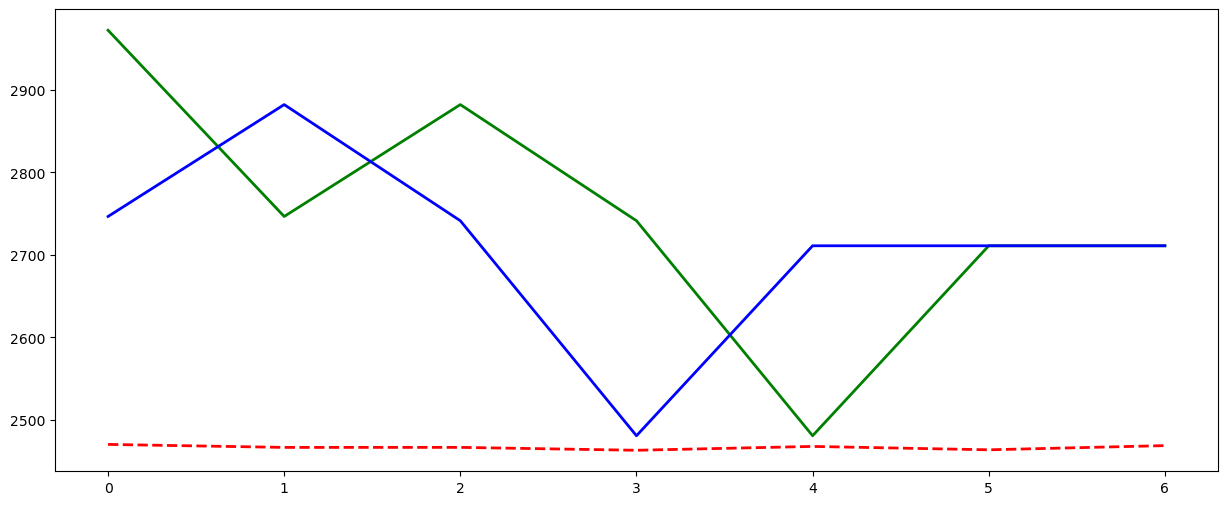

In [7]:
with torch.no_grad():
    index = 290
    src = torch.from_numpy(yahoo_testset.to_numpy()[index:(index + window_len), :]).to(torch.float32).unsqueeze(0)
    index += 1
    trg = torch.from_numpy(yahoo_testset.to_numpy()[index:(index + window_len), yahoo_class_idx]).to(torch.float32).unsqueeze(0).unsqueeze(-1)
    out = model(src.to(device))
    plt.figure(figsize=(15,6))
    # src_rec = scaler.inverse_transform(src[0, :, yahoo_class_idx])
    # trg_rec = scaler.inverse_transform(trg[0, :, 0])
    # out_rec = scaler.inverse_transform(out[0, :, 0])
    src = src[0, :, yahoo_class_idx].tolist()
    trg = trg[0, :, 0].tolist()
    out = out[0, :, 0].tolist()
    plt.plot(src, '-', color = 'green', label = 'Src', linewidth=2)
    plt.plot(trg, '-', color = 'blue', label = 'Target', linewidth=2)
    plt.plot(out, '--', color = 'red', label = 'Prediction', linewidth=2)
    plt.show()